
Here is a table with the results of an A / B test. The numeric column shows the revenue values ​​for each user for the period of the experiment.

Task
We need to understand whether we began to earn more per user or not. You already know about the existence of the t-test, the Mann-Whitney U-test, and the bootstrap. Open question: what tool to use?

1. Calculate p-value in three ways: t-test, U-test, bootstrap means

2. Compare the result between test and control for all these cases

3. Write the conclusions that can be drawn from the analysis of the applied criteria. Write why we should use this or that tool: what assumptions about the random variable should be kept, what conditions are necessary, etc.


Let's load the necessary libraries, and the data itself and convert them into a "working view"

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [3]:
import scipy.stats as st
import seaborn as sns
sns.set(rc={'figure.figsize': (12,6)}, style="whitegrid")

In [4]:
import pingouin as pg

In [5]:
hw = pd.read_csv('hw_bootstrap.csv', index_col=0, sep =';', decimal=',') 

In [6]:
hw.head()

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


In [7]:
hw.dtypes

value                float64
experimentVariant     object
dtype: object

In [8]:
hw.shape

(1000, 2)

In [9]:
hw.groupby('experimentVariant').size()
# find the number of observations in the control and exp. group

experimentVariant
Control      500
Treatment    500
dtype: int64

Now let's take a look at the hypotheses

Null hypothesis (H0): There is no difference between the average value in the test and control groups (they did not earn any more)

Alternative hypothesis (H1): There is a difference between the average value in the test and control groups (began to earn more)

Define alpha = 0.05

Let's do a little EDA


We study the distribution for normality in the test and exp. group

In [10]:
pg.normality(data=hw, dv='value', group='experimentVariant') 

# the method is sensitive to the number of observations in the sample (but we have a small one)

,W,pval,normal
experimentVariant,,,
Control,0.995925,2.242409e-01,True
Treatment,0.070389,1.093013e-43,False


In [11]:
# Let's do an extra test
pg.normality(data=hw, dv='value', group='experimentVariant', method='normaltest')

,W,pval,normal
experimentVariant,,,
Control,2.943459,2.295282e-01,True
Treatment,929.515767,1.439514e-202,False


According to the results of the test, the distribution (Treatment) is not normal.

Let's look at these distributions

We use the option with qq plots

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

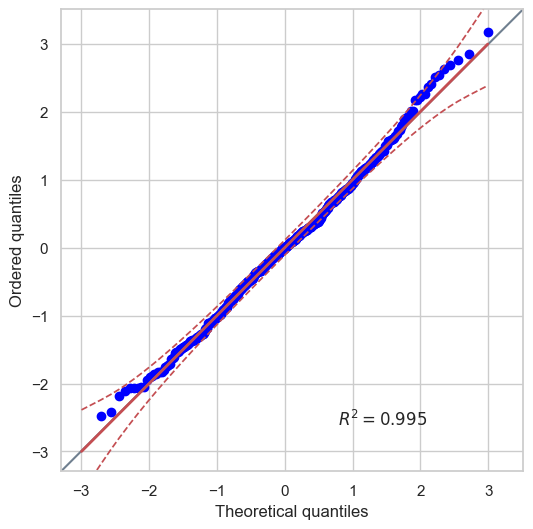

In [13]:
pg.qqplot(hw.query("experimentVariant == 'Control'").value)


If the graph lies on one line, then the distribution can be considered normal. However, there are some slight deviations from the norm.

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

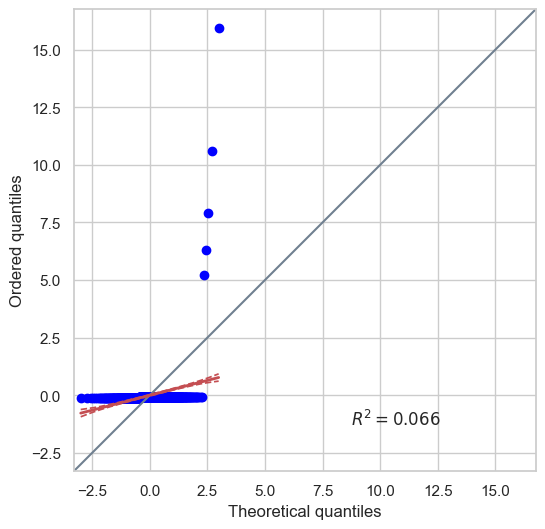

In [14]:
pg.qqplot(hw.query("experimentVariant == 'Treatment'").value)


According to the results of the test, the distribution (Treatment) is not normal.
Obviously there are outliers.


Let's take a closer look

In [15]:
hw[hw.experimentVariant == 'Treatment'].value.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

Let's make a small conclusion.

CONCLUSION: The t-test is susceptible to outliers. If we do not discard the outliers, then the use of the t-test is incorrect.

In [16]:

hw.tail() #we see that we have abnormal values

,value,experimentVariant
996,1000.0,Treatment
997,1200.0,Treatment
998,1500.0,Treatment
999,2000.0,Treatment
1000,3000.0,Treatment


In [17]:
hw[hw.experimentVariant == 'Treatment'].value.quantile(.99)

22.999042271425807


99% of observations value < 22.99. We definitely have outliers. Let's try to get rid of them, overwrite them in a separate variable

In [18]:
t = hw[(hw.experimentVariant == 'Treatment')]

In [19]:
t = t[t.value <= t.value.quantile(.99)].value

In [20]:
c = hw[hw.experimentVariant == 'Control'].value # for convenience, overwrite in a separate variable 


Now let's look at the distributions, Spanish hist

<Axes: >

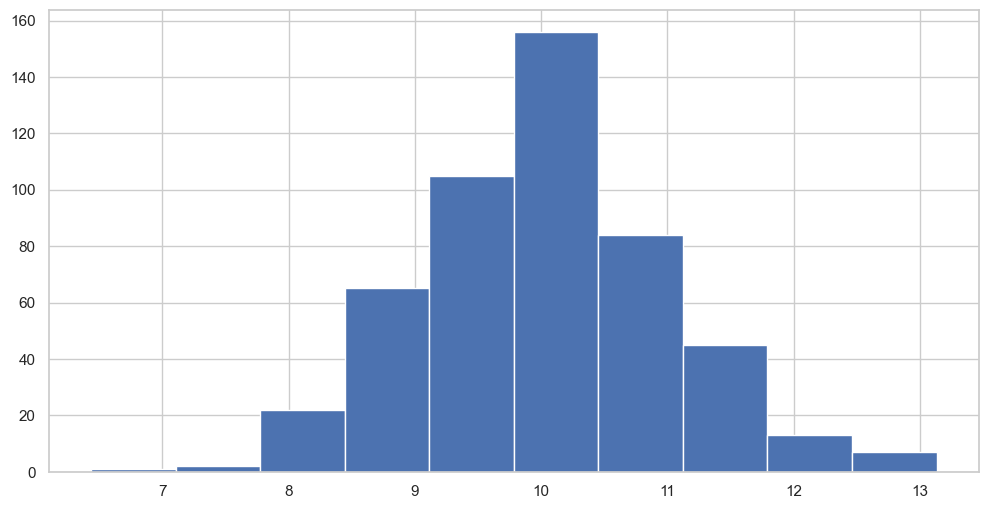

In [21]:
c.hist() #Control

<Axes: >

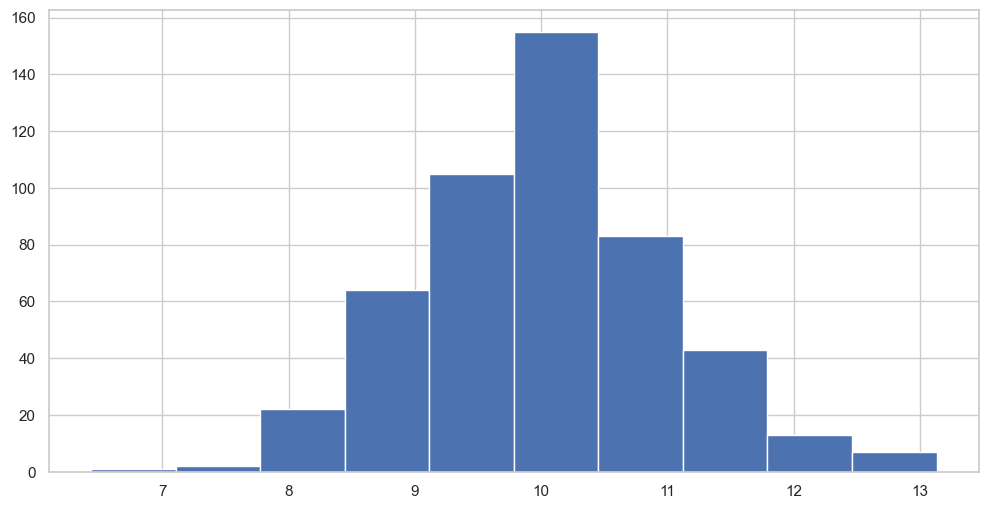

In [22]:
t.hist() #Treatment

In [23]:
t.min(), t.max()

(6.43654075863162, 13.130345728722)

In [24]:
c.min(), c.max()

(6.43654075863162, 13.130345728722)


Removed emissions. And it can be seen that the samples are the same


Now let's do a t-test

In [25]:
from scipy.stats import ttest_ind

In [26]:

# didn't throw out emissions
ttest_ind(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value, alternative='two-sided')

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

In [27]:

# threw out emissions
ttest_ind(c, t, alternative='two-sided', equal_var=False)

Ttest_indResult(statistic=0.0829918790194215, pvalue=0.9338747244170571)


Null hypothesis (H0): There is no difference between the average value in the test and control groups (they did not earn any more)

p > 0.05 . null hypothesis is not rejected

U-test Mann-Whitney

In [28]:
from scipy.stats import mannwhitneyu

In [29]:

# didn't throw out emissions
mannwhitneyu(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value, alternative='two-sided')

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

In [30]:

# threw out emissions
mannwhitneyu(t, c, alternative='two-sided')

MannwhitneyuResult(statistic=123310.5, pvalue=0.9228386264147465)


Mann-Whitney U-test - not sensitive to outliers


BOOTSTRAP

In [71]:
#create func

In [31]:
def get_bootstrap(
    data_column_1, # numeric values ​​of the first sample
    data_column_2, # numeric values ​​of the second sample
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, # the statistics we are interested in
    bootstrap_conf_level = 0.95 # significance level
):
    boot_data = []
    for i in tqdm(range(boot_it)): # extract subsamples
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # return parameter
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - apply statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [32]:
# we will try bootstrap on exp. distribution
np.random.seed(5)

In [33]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})


Let's perform a bootstrap analysis of the average on the initial data

  0%|          | 0/1000 [00:00<?, ?it/s]

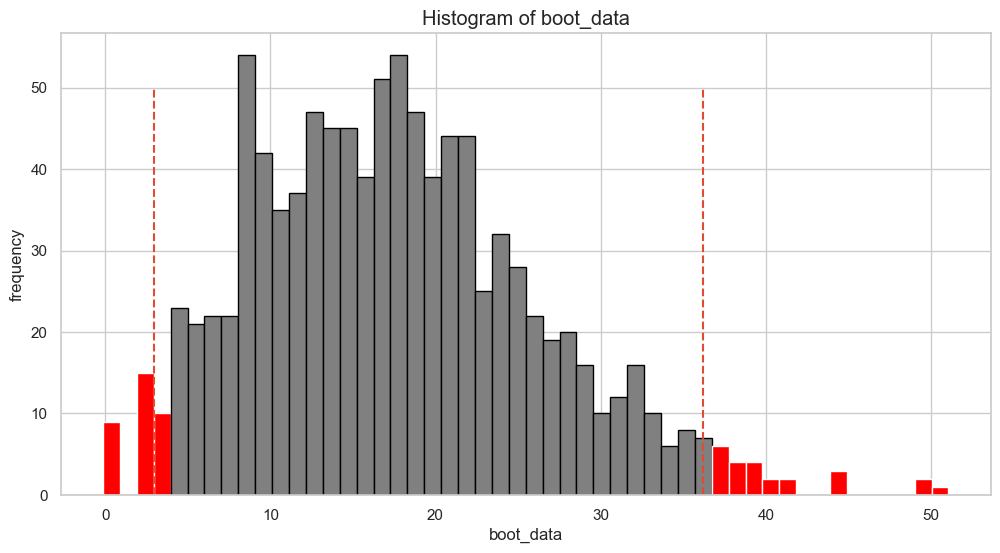

In [34]:
booted_data = get_bootstrap(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value)

In [37]:
booted_data["p_value"] # alpha

0.9383470084094176


Based on the data obtained, we cannot reject the alt-hypothesis (H1)

Something went wrong

Let's perform a bootstrap analysis of the average on the data from which outliers have been excluded

  0%|          | 0/1000 [00:00<?, ?it/s]

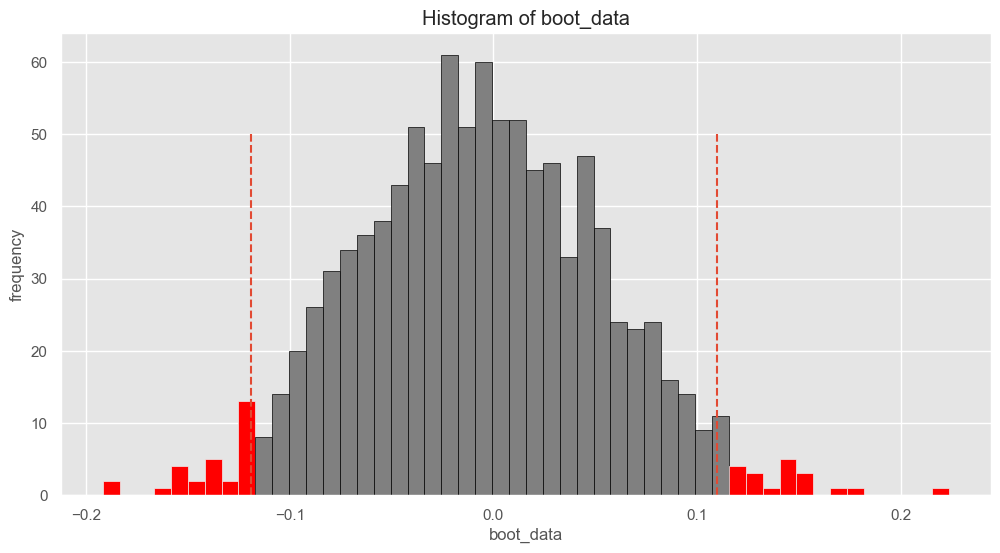

In [38]:
booted_data = get_bootstrap(t, c)

In [39]:
booted_data["p_value"] # alpha

0.9128686315164449


Null hypothesis (H0): There is no difference between the average value in the test and control groups (they did not earn any more)

p > 0.05 . null hypothesis is not rejected

In [43]:
booted_data["quants"] # confidence interval

,0
0.025,-0.113286
0.975,0.135202



The average depends on the outliers. You can use the median

  0%|          | 0/1000 [00:00<?, ?it/s]

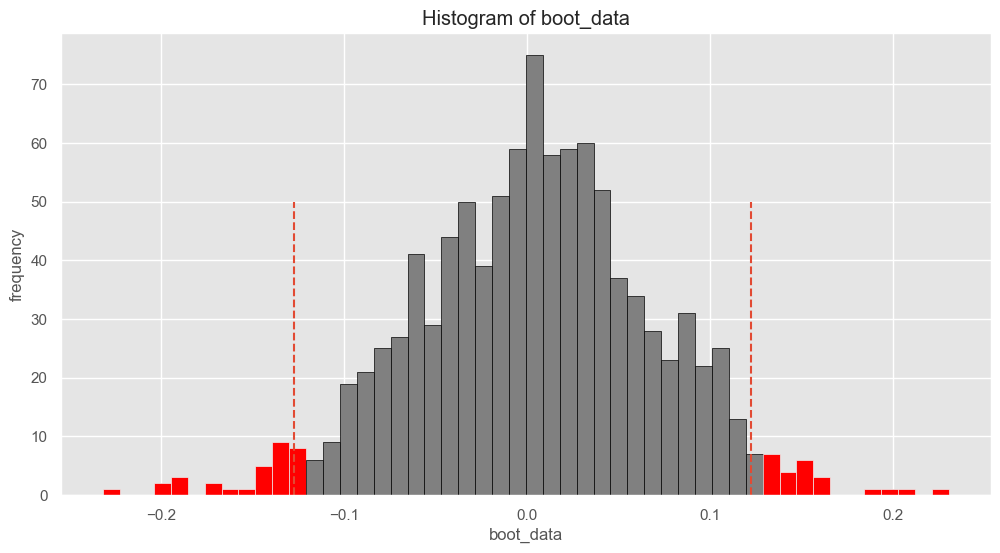

In [44]:
booted_data = get_bootstrap(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value, statistic=np.median)

In [45]:
booted_data["p_value"] # alpha

0.9483898053175861

In [46]:
booted_data["quants"] # confidence interval

,0
0.025,-0.127113
0.975,0.122482


Null hypothesis (H0): There is no difference between the average value in the test and control groups (they did not earn any more)

p > 0.05 . null hypothesis is not rejected

When we use the bootstrap stat.average (default) On the data where the outliers are stored, you can see the difference. And we do not reject the alternative hypothesis.

If we take not the average, but the median (which is more correct) in the case of outliers. then we do not reject the null hypothesis.


If there are outliers, then we cannot use the average.

Let's look at the p-value through:
boot mean
boot median
Man Whitney

For convenience, we will do this through a loop

  0%|          | 0/1000 [00:00<?, ?it/s]

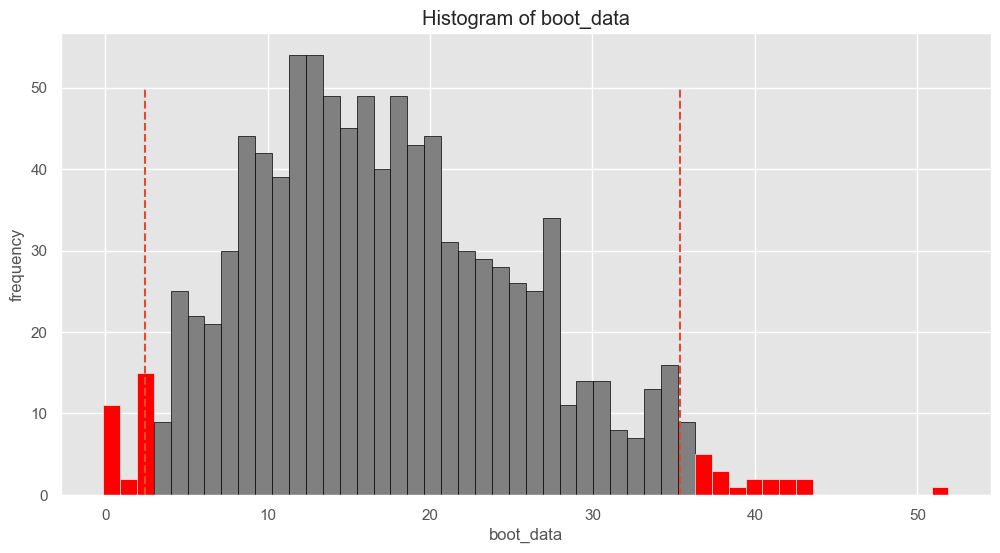

  0%|          | 0/1000 [00:00<?, ?it/s]

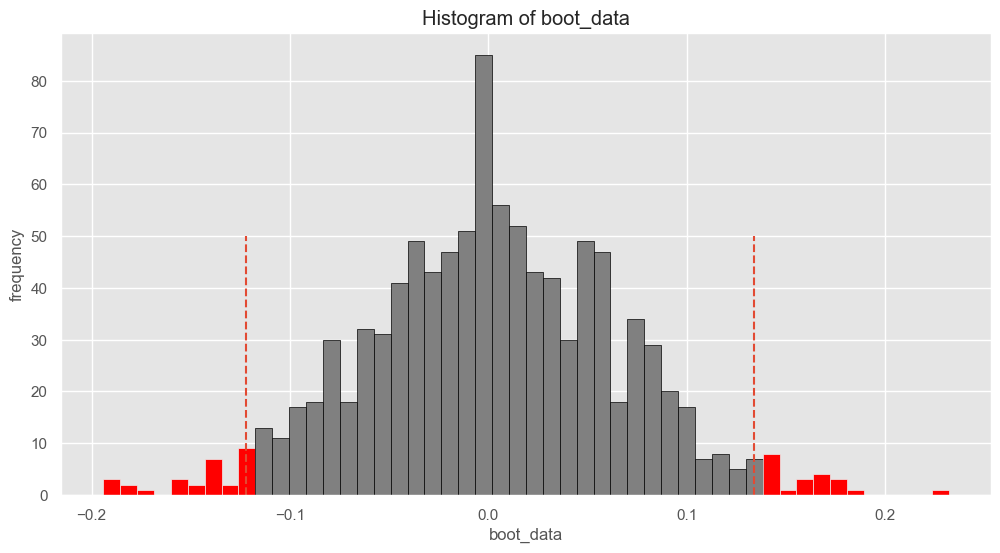

Boot mean: 0.04384410173803475, Boot median: 0.972160561454083, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


  0%|          | 0/1000 [00:00<?, ?it/s]

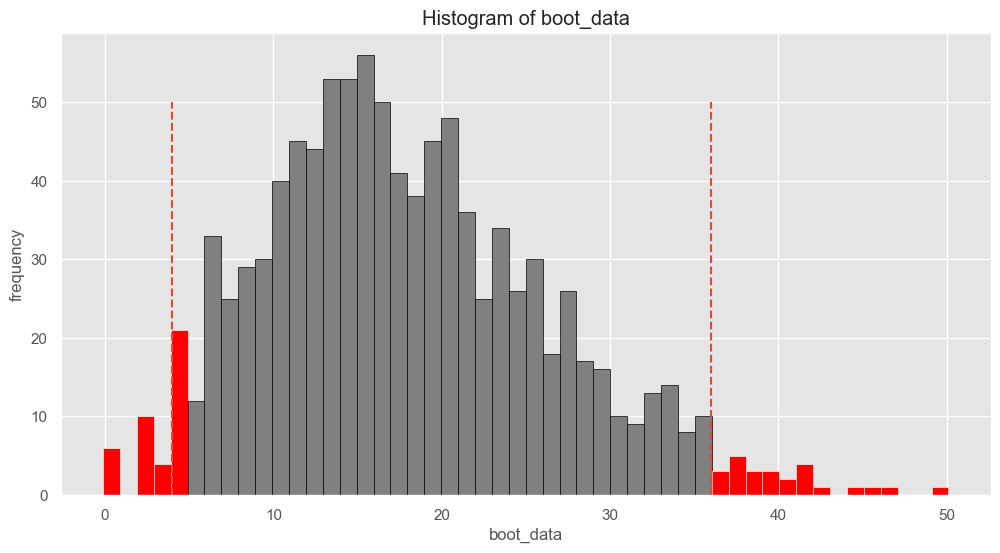

  0%|          | 0/1000 [00:00<?, ?it/s]

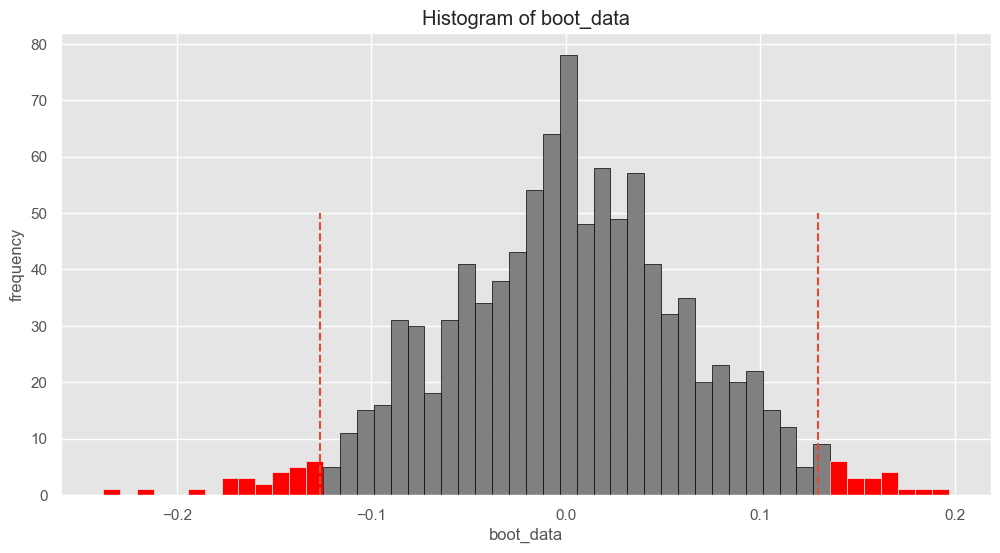

Boot mean: 0.03453521329781612, Boot median: 0.9834013898574684, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


  0%|          | 0/1000 [00:00<?, ?it/s]

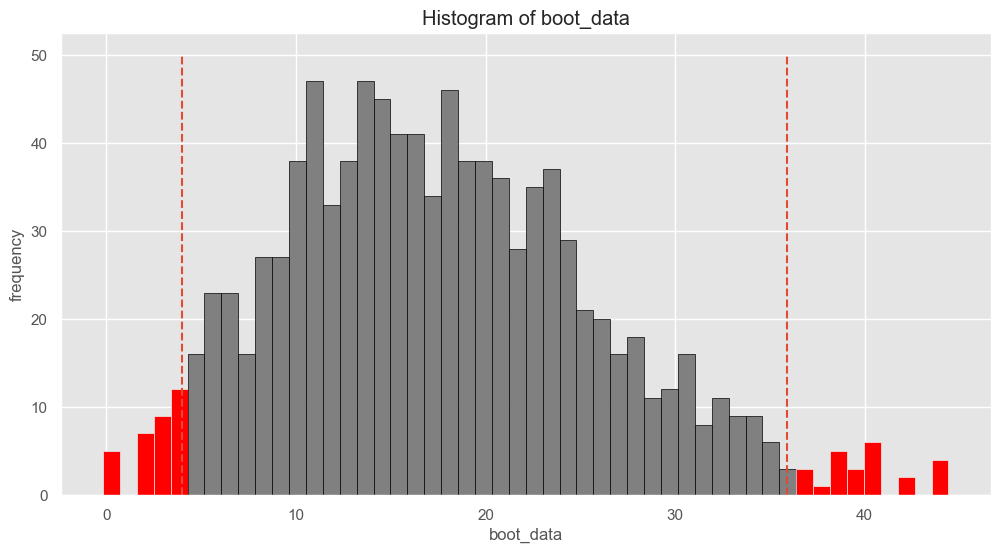

  0%|          | 0/1000 [00:00<?, ?it/s]

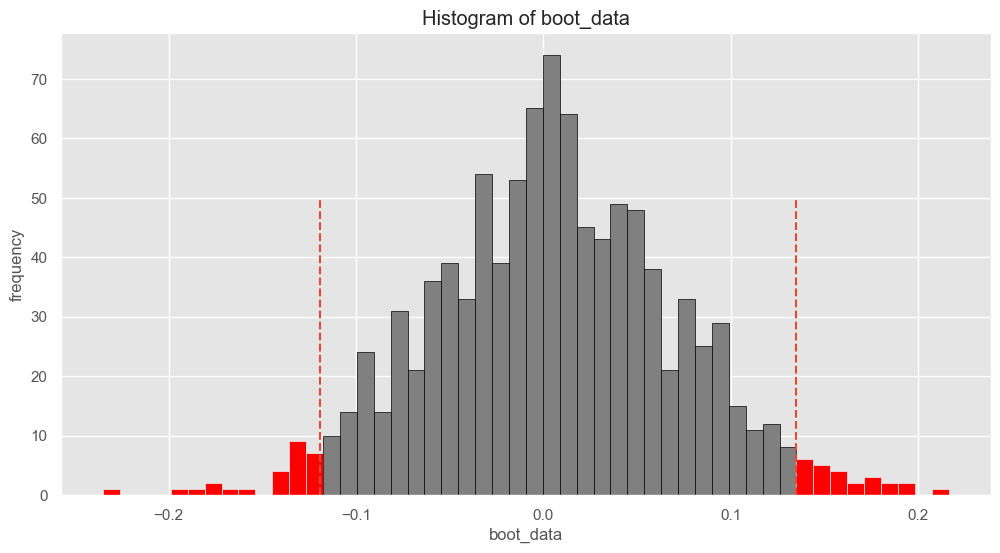

Boot mean: 0.03441247993967137, Boot median: 0.9364392464395084, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


  0%|          | 0/1000 [00:00<?, ?it/s]

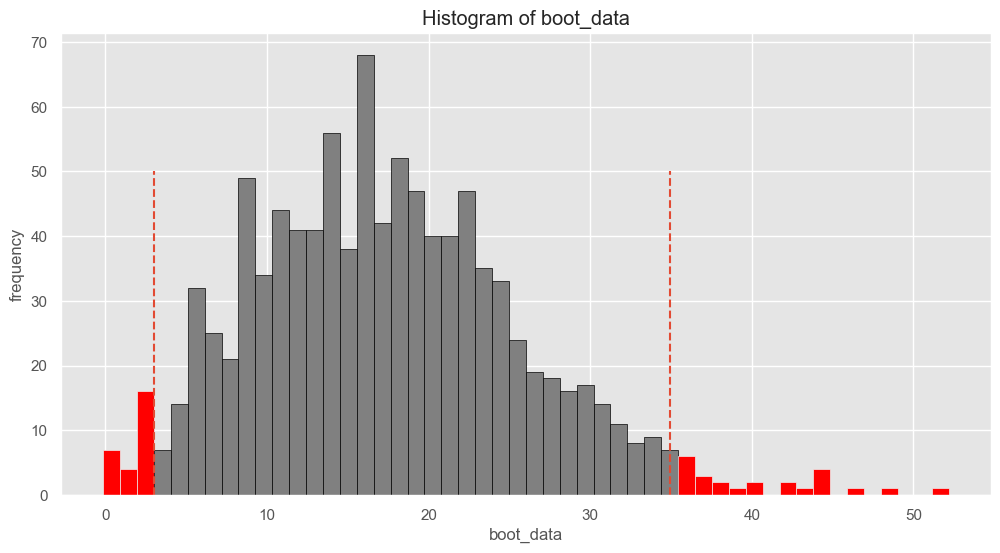

  0%|          | 0/1000 [00:00<?, ?it/s]

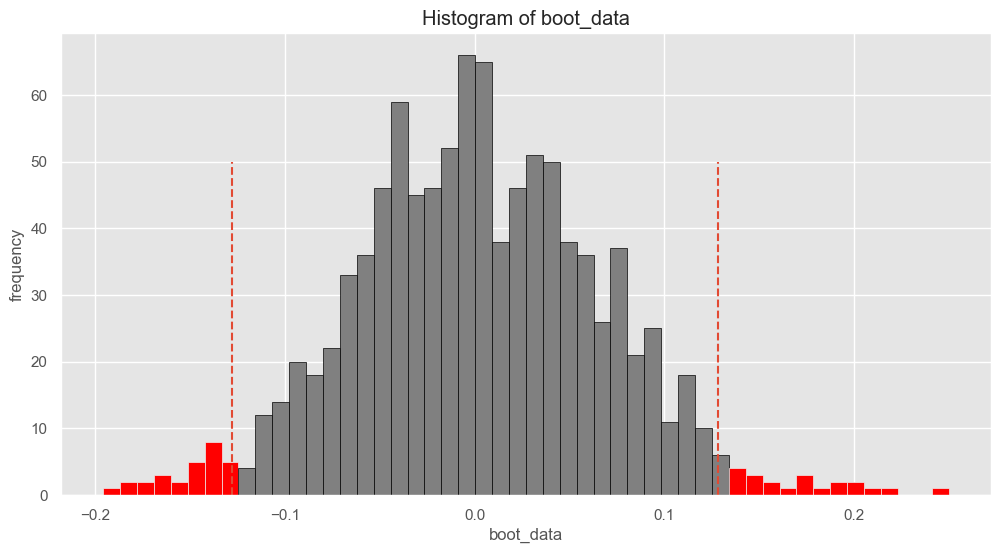

Boot mean: 0.03649106813839151, Boot median: 0.971429474888347, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


  0%|          | 0/1000 [00:00<?, ?it/s]

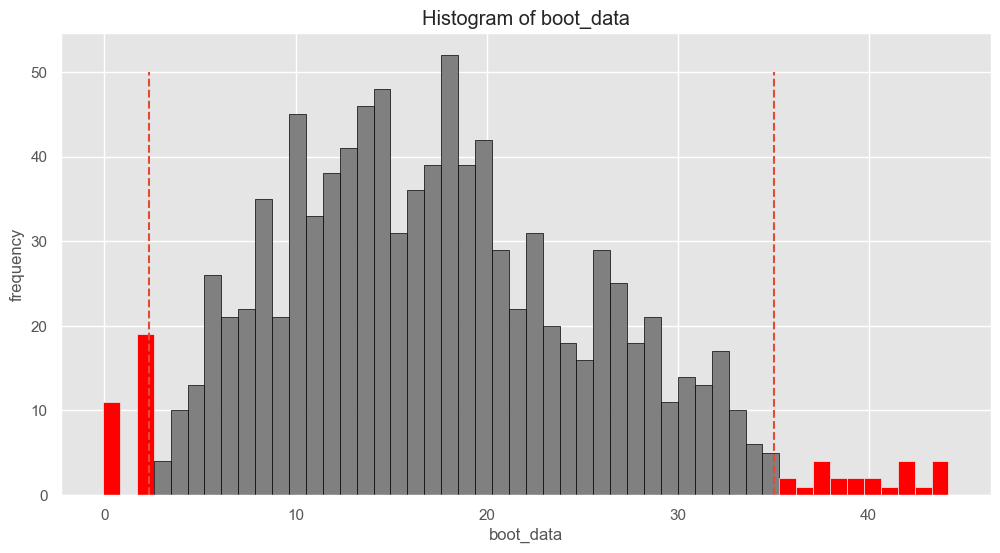

  0%|          | 0/1000 [00:00<?, ?it/s]

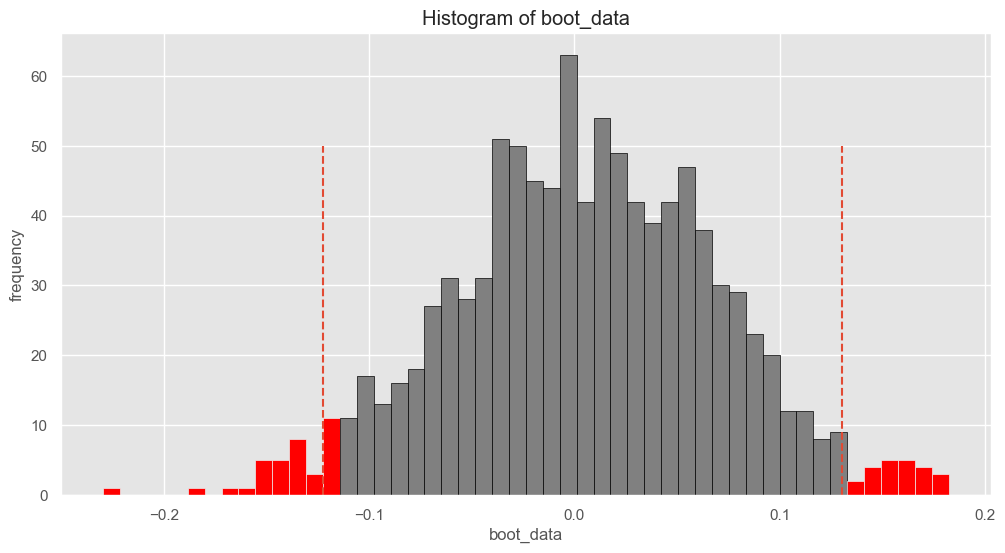

Boot mean: 0.042157260693471275, Boot median: 0.936630164477191, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


In [47]:
x = hw['value'][(hw['experimentVariant'] == 'Treatment')]
y = hw['value'][(hw['experimentVariant'] == 'Control')]

result_Mann = mannwhitneyu(x, y, alternative='two-sided')

for i in range(5):
    res_boot_mean = get_bootstrap(x, y)
    res_boot_median = get_bootstrap(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value, statistic=np.median)
    
    
    print(f'Boot mean: {res_boot_mean ["p_value"]}, Boot median: {res_boot_median ["p_value"]}, Mann Whitney: {result_Mann}')


CONCLUSIONS

1. Comparing the averages using the bootstrap p-value is approximately [0.03 - 0.04] And it turns out,
that we can reject the null hypothesis.

However, this did not work out with medians: the p-value is approximately [0.92 - 0.99]. It can be seen that

- p-values ​​according to bootstrap are relatively close to p-values ​​according to M.W [0.859].

The M.W hypothesis tests the presence/absence of a difference between distributions. We transform the sample into a rank form,
and see the ranks in the research. samples. Medians do not differ in bootstrap, and M.W (more precisely, the values ​​are close)
Bootstrap is more informative than M.W. variance is preserved, variance is not taken into account in M.W.

2. Doing t-test and bootstrap on average is not correct in this case. The methods are sensitive to outliers.
Because the mean itself is sensitive.

3. If we want to work with the two methods above (point 2). It is necessary to "get rid" of anomalies, well, bring the data back to normal
distribution (especially in the case of t-test).

4. M.W and bootstrap by median can be used on "raw" data. However, M.W is not so informative.

5. Comparing p-values, we do not reject the null hypothesis. And you can conclude that there is no earning more
we didn't become

